In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.8 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Cloning into 'kaggle-environments'...
remote: Enumerating objects: 4311, done.
remote: Counting objects: 100% (1091/1091), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 4311 (delta 871), reused 925 (delta 772), pack-reused 3220
Receiving objects: 100% (4311/4311), 11.00 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (2630/2630), done.
Processing /content/kaggle-environments
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for kaggle-environments: filename=kaggle_environments-1.9.9-py3-none-any.whl size=1820377 sha256=6f43f15b0a98b8e8dddd3f7fd483d8f1

In [27]:
#from gfootball.env.football_env import FootballEnv
from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math

#env_name = "GFootballBase-v0"
#print(env_name)

In [3]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,fc3_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    self.fc3_dims=fc3_dims
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.fc3_dims)
    self.fc3=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
      
    return actions


In [5]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

In [33]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 20000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=600, fc2_dims=600 , fc3_dims=600)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions (19)
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    for i in range(self.mem_size//self.batch_size):
      batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
      #batch=np.random.choice(max_mem,self.batch_size,replace=False)
      batch_index = np.arange(self.batch_size , dtype=np.int32)

      state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
      new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
      reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
      terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

      action_batch = self.action_memory[batch] 
    
      q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
      q_next = self.Q_eval.forward(new_state_batch)

      q_next[terminal_batch] = 0.0
      q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

      loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
      loss.backward()
      self.Q_eval.optimizer.step()

      self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min
      

shout ektos periohis episode 0 step= 2
---Avg reward last: -200.27911559184142 Avg score last 0.0 Avg steps 3.0 episode= 0 ---
shout ektos periohis episode 1 step= 6
shout ektos periohis episode 2 step= 3
shout ektos periohis episode 3 step= 12
shout ektos periohis episode 4 step= 6
ball is out -10 episode 5 step= 70
shout ektos periohis episode 6 step= 5
shout ektos periohis episode 7 step= 14
shout ektos periohis episode 8 step= 6
ball is out -10 episode 9 step= 156
---Avg reward last: -144.02468495081393 Avg score last 0.1 Avg steps 36.1 episode= 10 ---
ball is out -10 episode 17 step= 49
---Avg reward last: 3.1240423608286525 Avg score last 0.9 Avg steps 85.1 episode= 20 ---
ball is out -10 episode 21 step= 75
ball is out -10 episode 26 step= 79
ball is out -10 episode 29 step= 68
ball is out -10 episode 30 step= 44
---Avg reward last: -4.009477277601945 Avg score last 0.6 Avg steps 72.1 episode= 30 ---
ball is out -10 episode 31 step= 78
ball is out -10 episode 33 step= 139
ball i

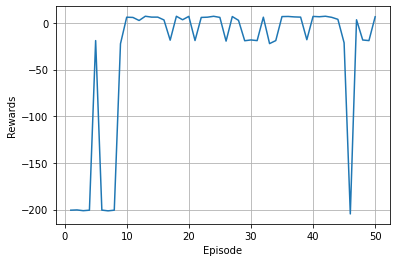

shout entos periohis episode 57 step= 85
---Avg reward last: 5.985357025382657 Avg score last 1.0 Avg steps 72.6 episode= 60 ---
shout entos periohis episode 61 step= 74
shout ektos periohis episode 62 step= 80
ball is out -10 episode 63 step= 50
ball is out -10 episode 68 step= 42
---Avg reward last: -19.752156584286404 Avg score last 0.7 Avg steps 63.4 episode= 70 ---
ball is out -10 episode 73 step= 43
ball is out -10 episode 74 step= 53
ball is out -10 episode 77 step= 66
---Avg reward last: -1.0520061535104803 Avg score last 0.7 Avg steps 59.1 episode= 80 ---
ball is out -10 episode 84 step= 40
shout entos periohis episode 85 step= 81
ball is out -10 episode 86 step= 32
ball is out -10 episode 87 step= 76
---Avg reward last: -1.1488569900935832 Avg score last 0.7 Avg steps 59.8 episode= 90 ---
ball is out -10 episode 91 step= 37
ball is out -10 episode 92 step= 47
ball is out -10 episode 93 step= 40
shout entos periohis episode 97 step= 79
---Avg reward last: -1.123821105515686 Av

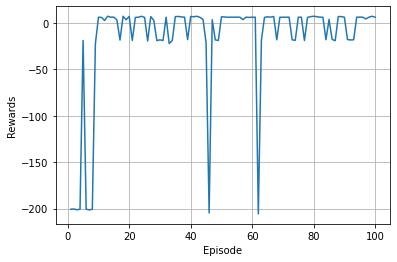

ball is out -10 episode 104 step= 34
ball is out -10 episode 105 step= 50
ball is out -10 episode 106 step= 38
ball is out -10 episode 109 step= 58
ball is out -10 episode 110 step= 111
---Avg reward last: -6.123496080812428 Avg score last 0.5 Avg steps 58.9 episode= 110 ---
ball is out -10 episode 115 step= 38
shout entos periohis episode 117 step= 101
shout entos periohis episode 119 step= 81
shout entos periohis episode 119 step= 85
---Avg reward last: 3.4649109232211956 Avg score last 0.9 Avg steps 70.4 episode= 120 ---
shout ektos periohis episode 121 step= 14
ball is out -10 episode 123 step= 41
ball is out -10 episode 130 step= 39
---Avg reward last: -19.134689993044802 Avg score last 0.7 Avg steps 50.3 episode= 130 ---
ball is out -10 episode 131 step= 67
shout ektos periohis episode 135 step= 53
ball is out -10 episode 137 step= 37
---Avg reward last: -19.637055158632418 Avg score last 0.7 Avg steps 60.0 episode= 140 ---
ball is out -10 episode 142 step= 43
ball is out -10 epi

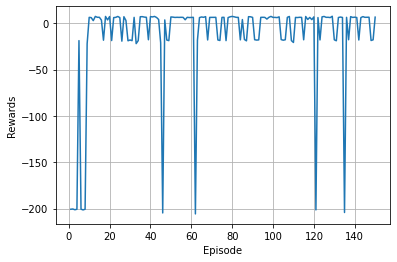

ball is out -10 episode 158 step= 37
---Avg reward last: 4.174064880260147 Avg score last 0.9 Avg steps 53.7 episode= 160 ---
ball is out -10 episode 161 step= 42
ball is out -10 episode 164 step= 47
ball is out -10 episode 165 step= 37
ball is out -10 episode 167 step= 37
ball is out -10 episode 169 step= 43
---Avg reward last: -5.795377730158781 Avg score last 0.5 Avg steps 52.0 episode= 170 ---
ball is out -10 episode 178 step= 38
shout entos periohis episode 179 step= 70
---Avg reward last: 3.812001399523183 Avg score last 0.9 Avg steps 67.1 episode= 180 ---
ball is out -10 episode 188 step= 76
---Avg reward last: 3.889157291646478 Avg score last 0.9 Avg steps 66.5 episode= 190 ---
ball is out -10 episode 191 step= 42
shout entos periohis episode 193 step= 90
ball is out -10 episode 195 step= 66
ball is out -10 episode 197 step= 34
ball is out -10 episode 198 step= 43
---Avg reward last: -3.6065465800150656 Avg score last 0.6 Avg steps 59.2 episode= 200 ---


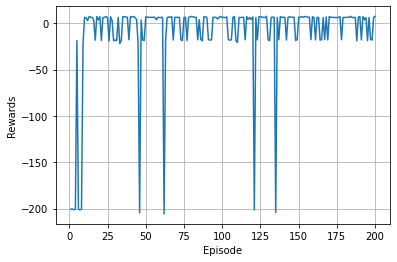

shout entos periohis episode 203 step= 88
ball is out -10 episode 207 step= 38
ball is out -10 episode 210 step= 77
---Avg reward last: 1.3625103416013107 Avg score last 0.8 Avg steps 59.7 episode= 210 ---
ball is out -10 episode 215 step= 47
shout ektos periohis episode 216 step= 15
ball is out -10 episode 217 step= 43
shout entos periohis episode 220 step= 79
---Avg reward last: -19.31791289305483 Avg score last 0.7 Avg steps 56.2 episode= 220 ---
ball is out -10 episode 222 step= 37
shout ektos periohis episode 227 step= 8
ball is out -10 episode 228 step= 50
ball is out -10 episode 229 step= 37
---Avg reward last: -21.574171465502836 Avg score last 0.6 Avg steps 48.3 episode= 230 ---
shout ektos periohis episode 232 step= 74
ball is out -10 episode 234 step= 45
shout ektos periohis episode 235 step= 67
shout entos periohis episode 236 step= 139
shout entos periohis episode 236 step= 141
shout entos periohis episode 236 step= 143
ball is out -10 episode 236 step= 145
ball is out -10

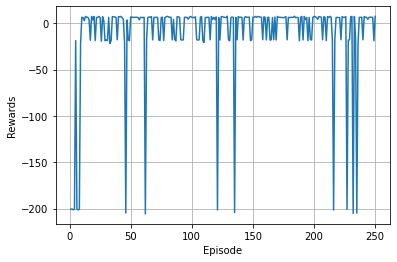

ball is out -10 episode 251 step= 76
ball is out -10 episode 253 step= 35
ball is out -10 episode 254 step= 41
shout entos periohis episode 255 step= 82
ball is out -10 episode 255 step= 98
---Avg reward last: -3.934286223514255 Avg score last 0.6 Avg steps 69.7 episode= 260 ---
ball is out -10 episode 263 step= 74
shout entos periohis episode 264 step= 92
ball is out -10 episode 266 step= 34
shout entos periohis episode 268 step= 80
shout entos periohis episode 268 step= 84
ball is out -10 episode 270 step= 39
---Avg reward last: -1.2342521111904805 Avg score last 0.7 Avg steps 60.6 episode= 270 ---
shout ektos periohis episode 271 step= 69
ball is out -10 episode 272 step= 46
ball is out -10 episode 273 step= 49
ball is out -10 episode 274 step= 74
shout entos periohis episode 275 step= 89
shout entos periohis episode 275 step= 92
ball is out -10 episode 275 step= 102
ball is out -10 episode 277 step= 39
shout entos periohis episode 278 step= 91
shout entos periohis episode 278 step=

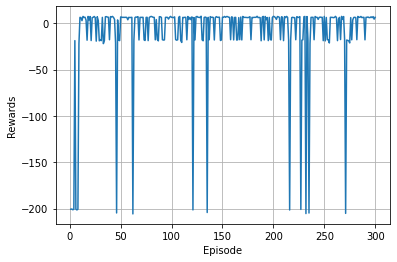

ball is out -10 episode 301 step= 52
ball is out -10 episode 304 step= 75
ball is out -10 episode 310 step= 35
---Avg reward last: -1.0041450574927782 Avg score last 0.7 Avg steps 60.2 episode= 310 ---
ball is out -10 episode 311 step= 49
ball is out -10 episode 312 step= 51
shout entos periohis episode 314 step= 100
ball is out -10 episode 316 step= 36
ball is out -10 episode 318 step= 39
ball is out -10 episode 320 step= 36
---Avg reward last: -6.005652765517656 Avg score last 0.5 Avg steps 53.1 episode= 320 ---
ball is out -10 episode 321 step= 78
shout entos periohis episode 324 step= 68
shout entos periohis episode 325 step= 86
shout entos periohis episode 325 step= 88
ball is out -10 episode 327 step= 46
ball is out -10 episode 328 step= 73
ball is out -10 episode 329 step= 71
---Avg reward last: -3.9474937334937996 Avg score last 0.6 Avg steps 69.2 episode= 330 ---
ball is out -10 episode 334 step= 37
---Avg reward last: 3.936949222679229 Avg score last 0.9 Avg steps 60.9 episod

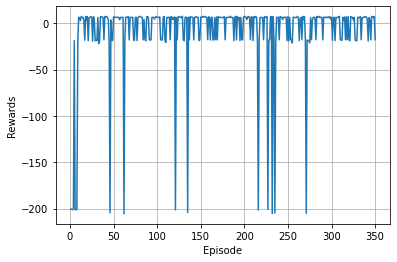

ball is out -10 episode 353 step= 78
ball is out -10 episode 356 step= 38
ball is out -10 episode 357 step= 37
---Avg reward last: -0.782704624900832 Avg score last 0.7 Avg steps 53.8 episode= 360 ---
shout ektos periohis episode 361 step= 8
ball is out -10 episode 362 step= 38
ball is out -10 episode 365 step= 37
ball is out -10 episode 366 step= 37
ball is out -10 episode 369 step= 79
---Avg reward last: -24.070572440659582 Avg score last 0.5 Avg steps 47.7 episode= 370 ---
shout entos periohis episode 371 step= 65
shout entos periohis episode 372 step= 84
shout entos periohis episode 372 step= 86
ball is out -10 episode 373 step= 44
shout entos periohis episode 374 step= 81
ball is out -10 episode 376 step= 44
shout entos periohis episode 377 step= 84
shout entos periohis episode 377 step= 86
shout entos periohis episode 377 step= 88
ball is out -10 episode 377 step= 98
ball is out -10 episode 378 step= 39
ball is out -10 episode 380 step= 35
---Avg reward last: -6.593957215283996 A

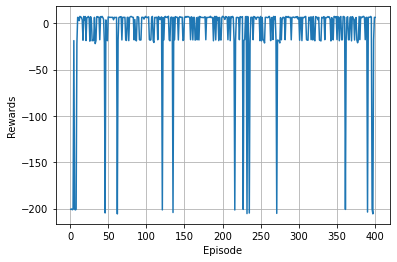

ball is out -10 episode 401 step= 44
shout entos periohis episode 407 step= 68
shout ektos periohis episode 408 step= 79
ball is out -10 episode 409 step= 39
---Avg reward last: -19.441286470577285 Avg score last 0.7 Avg steps 51.5 episode= 410 ---
ball is out -10 episode 413 step= 44
ball is out -10 episode 415 step= 76
shout entos periohis episode 415 step= 76
ball is out -10 episode 418 step= 75
ball is out -10 episode 420 step= 72
---Avg reward last: -3.394025586008172 Avg score last 0.6 Avg steps 57.4 episode= 420 ---
ball is out -10 episode 421 step= 44
ball is out -10 episode 423 step= 40
ball is out -10 episode 425 step= 38
ball is out -10 episode 426 step= 78
ball is out -10 episode 427 step= 76
ball is out -10 episode 428 step= 37
ball is out -10 episode 429 step= 77
ball is out -10 episode 430 step= 53
---Avg reward last: -13.315211490231501 Avg score last 0.2 Avg steps 53.3 episode= 430 ---
shout entos periohis episode 432 step= 73
shout entos periohis episode 434 step= 73


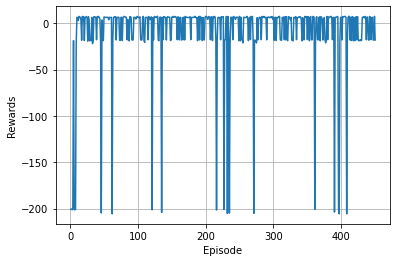

shout entos periohis episode 458 step= 84
---Avg reward last: 6.211245070220017 Avg score last 1.0 Avg steps 65.0 episode= 460 ---
shout ektos periohis episode 461 step= 74
shout entos periohis episode 462 step= 74
shout entos periohis episode 462 step= 76
ball is out -10 episode 463 step= 44
ball is out -10 episode 464 step= 39
ball is out -10 episode 465 step= 40
shout entos periohis episode 467 step= 76
ball is out -10 episode 467 step= 77
ball is out -10 episode 468 step= 42
shout entos periohis episode 469 step= 81
shout entos periohis episode 469 step= 83
shout entos periohis episode 469 step= 85
ball is out -10 episode 470 step= 35
---Avg reward last: -29.937020278515142 Avg score last 0.3 Avg steps 61.6 episode= 470 ---
ball is out -10 episode 474 step= 41
ball is out -10 episode 478 step= 79
---Avg reward last: 1.6254148693736206 Avg score last 0.8 Avg steps 53.6 episode= 480 ---
shout entos periohis episode 481 step= 80
ball is out -10 episode 481 step= 96
ball is out -10 epi

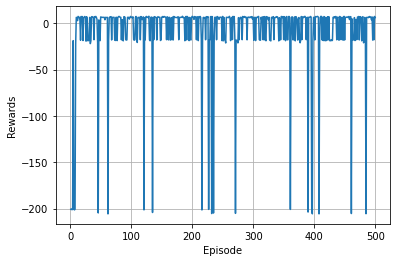

shout entos periohis episode 502 step= 83
shout entos periohis episode 503 step= 75
ball is out -10 episode 503 step= 76
ball is out -10 episode 506 step= 36
shout entos periohis episode 509 step= 76
---Avg reward last: 1.1138521911421246 Avg score last 0.8 Avg steps 66.7 episode= 510 ---
shout entos periohis episode 511 step= 84
shout entos periohis episode 511 step= 86
shout entos periohis episode 511 step= 88
shout entos periohis episode 511 step= 91
shout entos periohis episode 513 step= 66
ball is out -10 episode 514 step= 39
ball is out -10 episode 520 step= 41
---Avg reward last: 1.3791038143309702 Avg score last 0.8 Avg steps 58.6 episode= 520 ---
ball is out -10 episode 524 step= 39
ball is out -10 episode 525 step= 37
shout entos periohis episode 526 step= 82
shout entos periohis episode 526 step= 84
shout entos periohis episode 526 step= 86
shout entos periohis episode 527 step= 77
shout entos periohis episode 527 step= 79
ball is out -10 episode 529 step= 37
ball is out -10

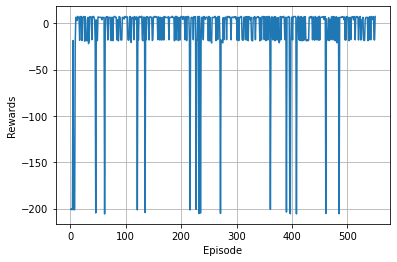

ball is out -10 episode 552 step= 53
ball is out -10 episode 553 step= 47
ball is out -10 episode 554 step= 76
ball is out -10 episode 558 step= 40
shout ektos periohis episode 559 step= 82
---Avg reward last: -24.664556724242306 Avg score last 0.5 Avg steps 58.0 episode= 560 ---
ball is out -10 episode 563 step= 44
shout entos periohis episode 564 step= 84
shout entos periohis episode 564 step= 86
ball is out -10 episode 566 step= 43
ball is out -10 episode 568 step= 70
ball is out -10 episode 569 step= 41
---Avg reward last: -3.624812191976693 Avg score last 0.6 Avg steps 58.4 episode= 570 ---
ball is out -10 episode 571 step= 42
ball is out -10 episode 572 step= 38
shout entos periohis episode 573 step= 82
ball is out -10 episode 573 step= 103
ball is out -10 episode 577 step= 36
shout entos periohis episode 578 step= 78
shout entos periohis episode 578 step= 80
ball is out -10 episode 578 step= 92
---Avg reward last: -6.403463967425648 Avg score last 0.5 Avg steps 62.0 episode= 580

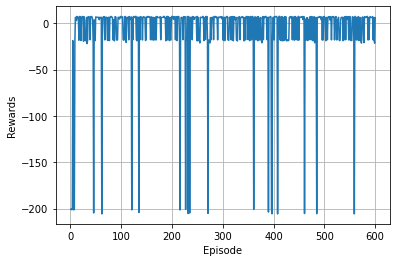

ball is out -10 episode 602 step= 47
ball is out -10 episode 603 step= 38
shout entos periohis episode 604 step= 76
shout entos periohis episode 604 step= 80
ball is out -10 episode 604 step= 91
ball is out -10 episode 606 step= 67
---Avg reward last: -3.6244856985641327 Avg score last 0.6 Avg steps 58.2 episode= 610 ---
shout ektos periohis episode 614 step= 43
ball is out -10 episode 615 step= 37
ball is out -10 episode 616 step= 80
shout entos periohis episode 616 step= 80
---Avg reward last: -19.535758312484713 Avg score last 0.7 Avg steps 57.9 episode= 620 ---
shout entos periohis episode 621 step= 84
shout entos periohis episode 621 step= 86
shout entos periohis episode 623 step= 77
shout entos periohis episode 623 step= 79
ball is out -10 episode 624 step= 38
ball is out -10 episode 627 step= 41
ball is out -10 episode 628 step= 40
---Avg reward last: -1.3692359963148453 Avg score last 0.7 Avg steps 63.7 episode= 630 ---
ball is out -10 episode 631 step= 66
shout ektos periohis 

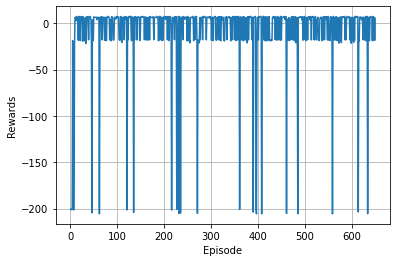

ball is out -10 episode 653 step= 38
ball is out -10 episode 656 step= 59
ball is out -10 episode 657 step= 35
shout entos periohis episode 660 step= 78
shout entos periohis episode 660 step= 80
---Avg reward last: -1.1091983644169174 Avg score last 0.7 Avg steps 57.6 episode= 660 ---
shout ektos periohis episode 661 step= 3


In [ ]:
#ANALYTIKA SXOLIA SE OLO TON KODIKA - MHN AFHSEIS KATI XORIS NA TO KATALABEIS
#TODO: if active player far from the ball, the reward will lose by the moving distance ---if we go out the square, the reward will lose - forward move else lose
#TODO: FTIAKSE PIO POLY TA CUSTOM REWARDS
#TODO:TYPOMA GRAMMI GRAMMI NA DEIS TIN EKPAIDEYSI
#TODO: MAKE BIGGER BATCHES



#if __name__ == '__main__':
#env = football_env.create_environment(env_name ='11_vs_11_easy_stochastic',render=False,representation='simple115')  #List with the 115 states 
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 
#env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0") #List with the 115 states
#env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_pass_and_shoot_with_keeper',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115')  #List with the 115 states 

#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 128 ,lr=0.00015 ,input_dims= [115], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0



num_of_eps = 1000
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i)
    #print("------------")

    #na bazei goal aytomata
    #if(observation[2]>0.6 and observation[95] == 1):
      
      
      #print("EXO MPALA",12)
      #new_observation,reward,done,info = env.step(12) #kanei shout Action 12

      #print("ball position",observation[88], "Action taken", action)
     
      
 
    if(act ==0 ):
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      act=1
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    
    action = agent.choose_action(observation)
    
    
    new_observation,reward,done,info = env.step(Action_list[action])

    #if(reward!=1):  #each step loses -0.2
      #reward= reward -0.2
    
    

    if(done ==1 and reward !=1): #if ball is out ,loses -2
      reward = reward -15
      print("ball is out -10","episode",i,"step=",steps)
    if(reward==1 and  done ==1): #if agent scores , wins +5
      reward = 10


    if((observation[2]<0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)

    if((observation[2]>0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis","episode",i,"step=",steps)
      
    reward = reward - ( math.sqrt( ((0.935 - observation[2])**2) + (0 -observation[3])**2 ) *0.1) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
    #if( ((observation[88]>0.99) and (observation[95]==1)) or  ((observation[89]>0.39) and (observation[95]==1)) or ((observation[89] < -0.39)and(observation[95]==1)) ):
      #reward =-2
      #print("bgike ektos")
    #if((reward!=1) or (reward!=-1)):
      #reward =cus_rew.custom_rew(observation,action,reward,new_observation)
    score= +reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #terminate if 500 episodes are correct 
  if(eps_rew == 1 ):
    terminal= terminal +1
    if(terminal == 500):
      print("500 Episodes with goal")
      break
  else:
      terminal =0 
  episode = episode +1 
  

  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
     
  
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  eps_rew=0



print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
#all_prints.score_graph(score_list,i+1)#i = num_of_eps
#print("\n ")
#all_prints.rew_graph(rew_list,i+1)


In [ ]:
class Custom_Rewards():
  #def __init__(self):
    #self.obs=obs    
    #self.action=action
    #self.reward =reward
  def custom_rew(self,obs,action,reward,new_obs):
    
    self.obs=obs
    self.action = action
    self.reward = reward
    self.new_obs=new_obs
    
    
#if the next action is shooting the ball, the reward will gain 0.2 point ||
#an exo ti mpala kai einai se apostasi x > 0.5 sto gipedo kai exei kanei shout einai kalo    
    if(self.obs[95] == 1 and self.obs[88] > 0.6 and self.action == 12):
      self.reward += 0.02
      #print("EKANE SHOUT MPROSTA APO TO KENTRO ,+0.1")
      return self.reward

    #An kanei shout piso apo to kentro na xanei ligo
    elif(self.obs[95]==1 and self.obs[88] < 0 and self.action == 12):
      self.reward -= 0.02
      #print("EKANE SHOUT PISO APO TO KENTRO, -0.05")
      return self.reward

# if we steal the ball, the reward will gain 0.05 points
    elif self.obs[96] == 1 and self.new_obs[95] == 1:  #obs[96] ball owner right team / obs[95] ball owner left team
        self.reward += 0.05
        #print("PHRE THN MPALA APO TON ANTIPALO , +0.05")
        return self.reward
#if we lose the ball, the reward will lose 0.05 points
    elif self.obs[95] == 1 and self.new_obs[96] == 1:
        self.reward -=0.02
        #print("PHRE THN MPALA O ANTIPALOS , -0.02")
        return self.reward
    else:
      return self.reward


#TODO: if active player far from the ball, the reward will lose by the moving distance

In [ ]:
#print(score_list or reward_list)

In [ ]:

"""print(observation)
new_observation,reward,done,info = env.step(4)
print(new_observation)"""

'print(observation)\nnew_observation,reward,done,info = env.step(4)\nprint(new_observation)'

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
"""env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
observation =env.reset()
new_observation,reward,done,info = env.step(action)
val=info.values()
print(val)
list_val=list(val)
list_val"""